In [12]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
set.seed(999)

### Using Cholesterol, Fasting Blood Sugar, and Age to Classify Heart Disease Patients from Cleveland
**Introduction**  

Heart (cardiovascular) disease is a term displaying the wide range of heart conditions directly affecting the heart, associated blood vessels, and muscles surrounding the heart (Heart and Stroke Foundation Canada, n.d.). Such effects can result in long-term or short-term effects on the function of the heart itself, spreading to other internal organs. Amongst the range of “heart” diseases, coronary artery disease, commonly found in the United States, is where the patients' blood vessels are narrowed and constricts the amount of blood supplying the heart. There is a multitude of prospective factors that may influence the likelihood of developing coronary artery disease or any variant of cardiovascular disease, including but not limited to, fasting blood sugar, cholesterol, and age.

Increased intake of cholesterol can build up inside of the blood vessels and restrict the flow to the heart, brain, lungs and kidneys (Centers for Disease Prevention and Control, 2022). Similarly, studies have observed and indicated fasting blood sugar as an underlying predictor of heart disease and the effects on the heart (National Library of Medicine, 2013). Additionally, the heart is considered a muscle and therefore weakens within aging. Older hearts rest at lower heart rates, which can lead to build up against the lining of the arteries, preventing blood pressure stabilization (Swiner, 2023).

The objective of this project is to classify and categorize patients on their potential risk in developing heart disease.  

The question we will be addressing is: **What is the likelihood of a patient at risk for heart disease based on their cholesterol, fasting blood sugar, and age?**

In [36]:
# Below we have read in the heart_disease URL and tidied the data into a table of only 
# the columns we want to use. The column names and values in the heart_disease colunm 
# have been renamed for ease of understanding.

heart_data <- read_csv("https://raw.githubusercontent.com/fellasleep2324/dsci-100-2023-24-grp12/main/heart.csv") 

heart_data[ heart_data == "?" ] <- NA

heart_tidy <- heart_data  |>
select(age, fbs, chol, target) |> # age: age of the patient

    rename(fast_bs = fbs, # fast_bs: fasting blood sugar 0 = < 120 mg/dL, 1 = > 120 mg/dL
           cholesterol = chol, # cholesterol in mg/dL
           heart_disease = target) |> # presence of heart disease

    mutate(heart_disease = as_factor(heart_disease)) |>
    mutate(heart_disease = fct_recode(heart_disease, "Yes" = "1", "No" = "0"))
    
head(heart_tidy)

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,fast_bs,cholesterol,heart_disease
<dbl>,<dbl>,<dbl>,<fct>
52,0,212,No
53,1,203,No
70,0,174,No
61,0,203,No
62,1,294,No
58,0,248,Yes


Then the tidy data is split into training and testing data sets. The percentage of total rows from heart_data has also been calculated using the training_heart set to confirm a correct splitting ratio.

In [37]:
heart_tidy_split <- initial_split(heart_tidy, props = 0.75, strata = heart_disease)
training_heart <- training(heart_tidy_split)
testing_heart <- testing(heart_tidy_split)

split_percent <- round(nrow(training_heart)/ (nrow(training_heart) + nrow(testing_heart)) * 100)

split_percent

[1] 75

In [38]:
# All three data sets, heart_data, training_heart and testing_heart are summarized and the 
# ratio of positive and negative values for the heart_disease column are calculated and
# returned to ensure the split data sets are consistent with the original tidy data. 

num_obs_heart = nrow(heart_tidy)
num_obs_training = nrow(training_heart)
num_obs_testing = nrow(testing_heart)

heart_data_percent <- heart_tidy |>
    group_by(heart_disease) |>
    summarize(total = n(),
             percentage_total = round(n() / num_obs_heart * 100, 2))

training_heart_percent <- training_heart |>
    group_by(heart_disease) |>
    summarize(total = n(),
             percentage_training = round(n() / num_obs_training * 100, 2))

testing_heart_percent <- testing_heart |>
    group_by(heart_disease) |>
    summarize(total = n(),
             percentage_testing = round(n() / num_obs_testing * 100, 2))

heart_data_percent
training_heart_percent
testing_heart_percent

heart_disease,total,percentage_total
<fct>,<int>,<dbl>
No,499,48.68
Yes,526,51.32


heart_disease,total,percentage_training
<fct>,<int>,<dbl>
No,374,48.7
Yes,394,51.3


heart_disease,total,percentage_testing
<fct>,<int>,<dbl>
No,125,48.64
Yes,132,51.36


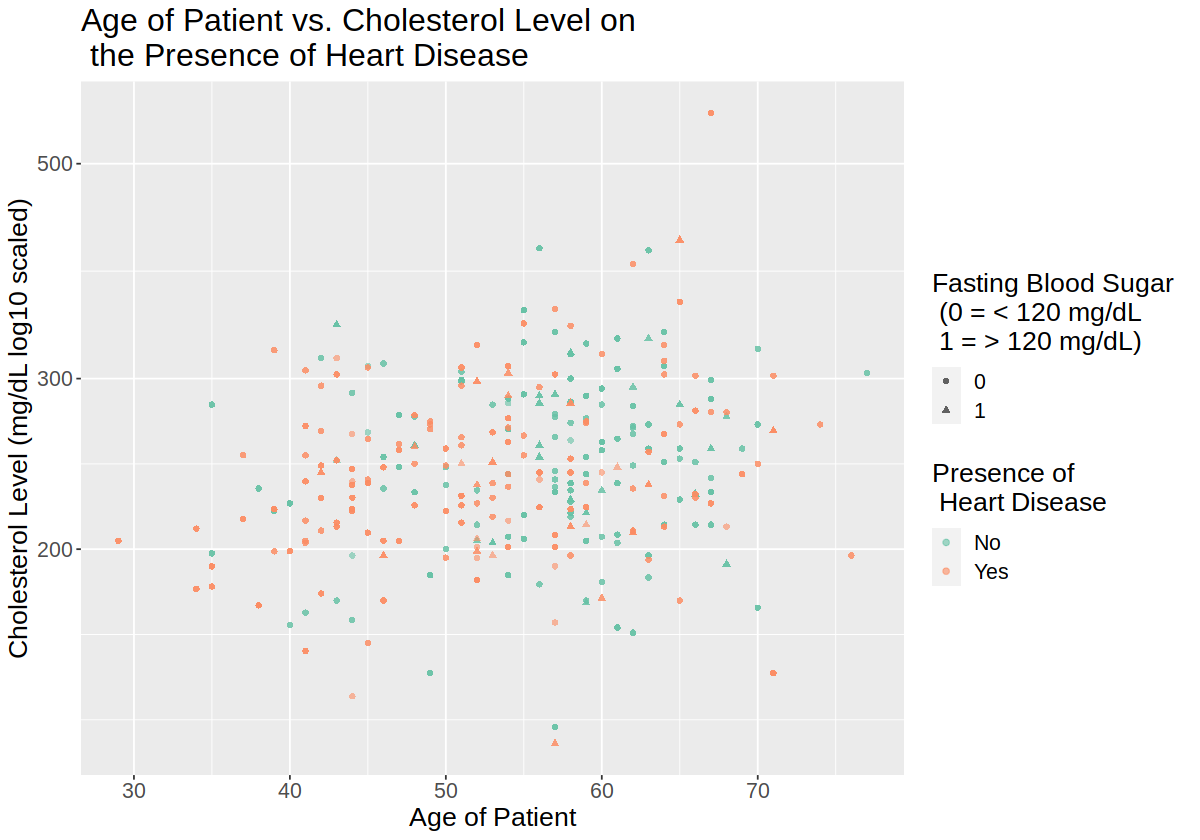

In [39]:
# Below is some exploratory visualization. It shows there is a loose correlation between the age 
# of a patient and their cholesterol in determining the presence of heart disease.

options(repr.plot.width = 10, repr.plot.height = 7)

heart_disease_plot <- training_heart |>
    ggplot(aes(x = age, y = cholesterol, color = heart_disease, shape = as_factor(fast_bs))) + 
        geom_point(alpha = 0.6) +
        ggtitle("Age of Patient vs. Cholesterol Level on \n the Presence of Heart Disease") +
        labs(x = "Age of Patient",
             y = "Cholesterol Level (mg/dL log10 scaled)",
             color = "Presence of \n Heart Disease", 
             shape = "Fasting Blood Sugar \n (0 = < 120 mg/dL \n 1 = > 120 mg/dL)") +
        scale_y_log10(labels = comma) +
        scale_color_brewer(palette = "Set2") +
        theme(text = element_text(size = 16),
              legend.direction = "vertical")
            
heart_disease_plot

**Methods**  
We will analyze our data with the K – nearest neighbors classification algorithm, which predicts new observations given the K number of nearest neighbors and the category predictors. We will use cholesterol, fasting blood sugar, and age as our predictor variables to classify whether the patient is susceptible to heart disease (reasons stated in introduction). We will perform cross-validation, where the overall training dataset is split into a validation and training set, to estimate the current data’s ability to predict unseen data. Cross-validation is important because we can estimate using our available data, meaning no new patient observations are required, and it helps determine the value of K that reduces under/overfitting. Furthermore, we will investigate the classifiers performance based on its accuracy, precision, and recall to conclude if the classifier is useful.

The points on the scatterplot will be colored according to the classification category. New data will be colored a different color from the categories to help recognize that it is unseen data and its nearest neighbors. 

**Expected Outcomes and Significance**  

Our expectation is that individuals who have been diagnosed with heart disease will, on average, exhibit higher levels of cholesterol, have low fasting blood sugar and tend to be older in age.  

Creating a K - nearest neighbors classification system for heart disease can simplify and improve the accuracy of diagnosis by health care professionals. This can ultimately lead to timely intervention and treatment.